# Data Wrangling

In [307]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

In [313]:
folder = 'C:/DS/Springboard/relax_challenge/'
user_df = pd.read_csv(folder+'takehome_users.csv',encoding = "ISO-8859-1")
login_df = pd.read_csv(folder+'takehome_user_engagement.csv',encoding = "ISO-8859-1")

In [309]:
print(user_df.head())
print(user_df.info())

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [302]:
print(login_df.head())
print(login_df.info())

            time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


In [317]:
# convert object time series to datetime
user_df['creation_time'] = pd.to_datetime(user_df['creation_time'],format='%Y/%m/%d %H:%M:%S', errors='coerce')
user_df['last_session_creation_time'] = pd.to_datetime(user_df['last_session_creation_time'],unit='s') # convert unix time 


In [318]:
# split email address
user_df[['email_address','email_company']] = user_df['email'].str.split('@',expand=True)
# drop all punctuation in email company column
import string
#user_df['email_company'] = user_df['email_company'].apply(lambda x: x.replace(string.punctuation,''))  # does not work
exclude = set(string.punctuation)
user_df['email_company'] = user_df['email_company'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_address,email_company
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,AugustCClausen,yahoocom
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,MatthewPoole,gustrcom
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,MitchellBottrill,gustrcom
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,NicklasSClausen,yahoocom
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,GraceRaw,yahoocom


<div class="alert alert-success">
<b>Summary of Data Wrangling: </b>   
- user_df has 10 columns, including information such as user id, account creation time, user name, email, last session creation time, opted to mailing list, enabled_for_marketing_drip, creation source, orgnization id, invited_by_user_id. In particular, two columns "last_session_creation_time" and "invited_by_user_id" have NULL values  
- user email in user_df is splited since the email suffix can be a more useful feature than the name part  
- login_df has 3 columns including login time, user id, and visit 
</div>

# Find adopted user

In [319]:
login_df['time_stamp'] = pd.to_datetime(login_df['time_stamp'],format='%Y/%m/%d %H:%M:%S', errors='coerce')
login_df['day_dif'] = login_df.groupby('user_id')['time_stamp'].apply(lambda x: x.dt.date.diff())
print(login_df.head())
# check if any login is within a day
print(len(login_df[login_df.day_dif == timedelta(days=0)]))

           time_stamp  user_id  visited           day_dif
0 2014-04-22 03:53:30        1        1               NaN
1 2013-11-15 03:45:04        2        1               NaT
2 2013-11-29 03:45:04        2        1  14 days 00:00:00
3 2013-12-09 03:45:04        2        1  10 days 00:00:00
4 2013-12-25 03:45:04        2        1  16 days 00:00:00
0


In [320]:
# count days of logins using a 7-day rolling window
login_user = login_df.set_index('time_stamp').groupby('user_id').rolling('7d')["visited"].count().reset_index(name='visit_count')
print(login_user.head(15))
# find adopted users
adp_user = login_user[login_user.visit_count >= 3]['user_id'].drop_duplicates()
adp_user = adp_user.reset_index()
print(len(adp_user))

    user_id          time_stamp  visit_count
0         1 2014-04-22 03:53:30          1.0
1         2 2013-11-15 03:45:04          1.0
2         2 2013-11-29 03:45:04          1.0
3         2 2013-12-09 03:45:04          1.0
4         2 2013-12-25 03:45:04          1.0
5         2 2013-12-31 03:45:04          2.0
6         2 2014-01-08 03:45:04          1.0
7         2 2014-02-03 03:45:04          1.0
8         2 2014-02-08 03:45:04          2.0
9         2 2014-02-09 03:45:04          3.0
10        2 2014-02-13 03:45:04          3.0
11        2 2014-02-16 03:45:04          2.0
12        2 2014-03-09 03:45:04          1.0
13        2 2014-03-13 03:45:04          2.0
14        2 2014-03-31 03:45:04          1.0
1602


In [321]:
print(len(login_df.user_id.unique()))
adp_user[:5]

8823


,index,user_id
0,9,2
1,27,10
2,312,20
3,331,33
4,354,42


In [322]:
# add a column in the user_df to represent whether the user is adopted
user_df['adopted'] = 0
user_df.loc[user_df.object_id.isin(adp_user.user_id),'adopted'] = 1
print(user_df['adopted'].sum())
print(user_df['adopted'].iloc[0:5])

1602
0    0
1    1
2    0
3    0
4    0
Name: adopted, dtype: int64


# Exploratory Data Analysis

In [323]:
import seaborn as sns
color = sns.color_palette()

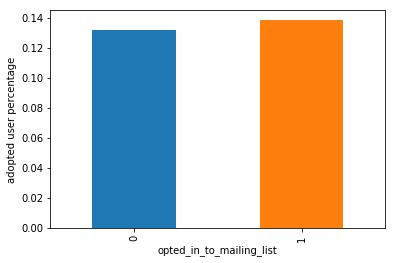

In [324]:
user_df.groupby('opted_in_to_mailing_list')['adopted'].mean().plot(kind='bar')
plt.ylabel('adopted user percentage')
plt.show()

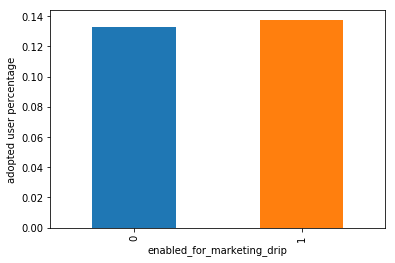

In [325]:
user_df.groupby('enabled_for_marketing_drip')['adopted'].mean().plot(kind='bar')
plt.ylabel('adopted user percentage')
plt.show()

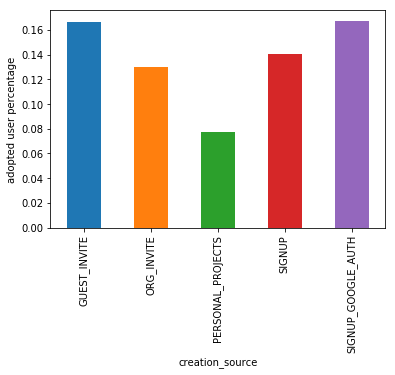

In [326]:
user_df.groupby('creation_source')['adopted'].mean().plot(kind='bar')
plt.ylabel('adopted user percentage')
plt.show()

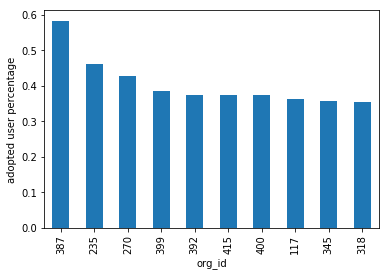

In [327]:
user_org = user_df.groupby('org_id')['adopted'].mean().reset_index(name='org_mean').sort_values(by='org_mean',ascending=False)
user_org.iloc[:10,1].plot(kind='bar',color=color[0])
plt.ylabel('adopted user percentage')
plt.xlabel('org_id')
plt.show()

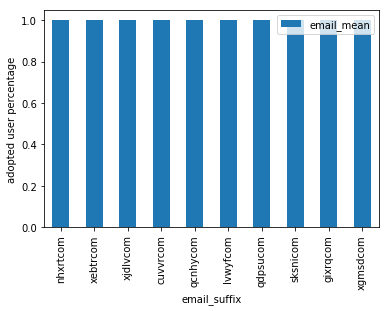

In [328]:
user_email = user_df.groupby('email_company')['adopted'].mean().reset_index(name='email_mean').sort_values(by='email_mean',ascending=False)
user_email.iloc[:10,:].plot(x='email_company', y='email_mean', kind='bar',color=color[0])
plt.ylabel('adopted user percentage')
plt.xlabel('email_suffix')
plt.show()

729 days 23:15:52
736 days 06:38:44


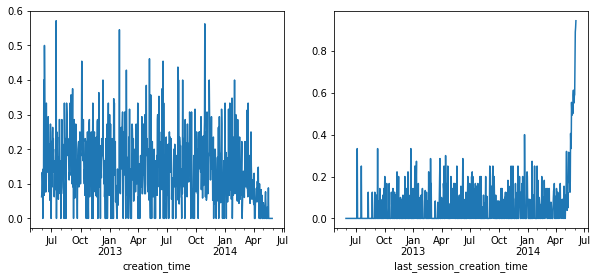

In [329]:
print(max(user_df['creation_time'])-min(user_df['creation_time']))
print(max(user_df['last_session_creation_time'])-min(user_df['last_session_creation_time']))
user_df_cre = user_df.set_index('creation_time')
user_cre = user_df_cre['adopted'].resample('1d').mean()
user_df_lst = user_df.set_index('last_session_creation_time')
user_lst = user_df_lst['adopted'].resample('1d').mean()

fig = plt.figure(figsize=(10,4))
a = fig.add_subplot(121)
user_cre.plot()

b = fig.add_subplot(122)
user_lst.plot()

plt.show()

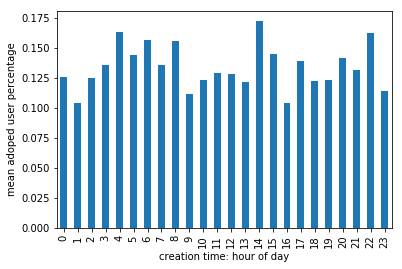

In [330]:
user_df.groupby(user_df.creation_time.dt.hour)['adopted'].mean().plot(kind="bar",color=color[0])
plt.xlabel('creation time: hour of day')
plt.ylabel('mean adoped user percentage')
plt.show()

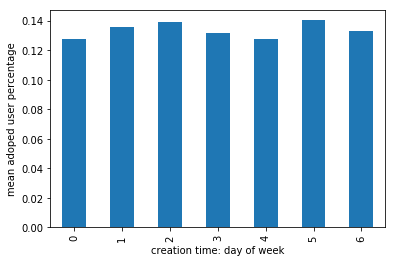

In [331]:
user_df.groupby(user_df.creation_time.dt.weekday)['adopted'].mean().plot(kind="bar",color=color[0])
plt.xlabel('creation time: day of week')
plt.ylabel('mean adoped user percentage')
plt.show()

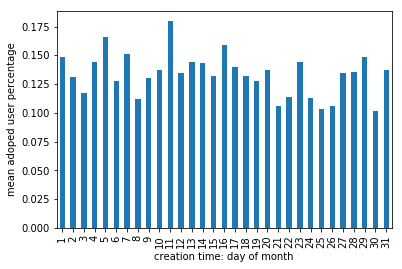

In [332]:
user_df.groupby(user_df.creation_time.dt.day)['adopted'].mean().plot(kind="bar",color=color[0])
plt.xlabel('creation time: day of month')
plt.ylabel('mean adoped user percentage')
plt.show()

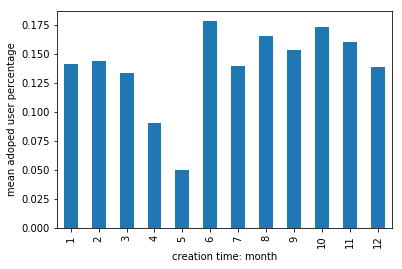

In [333]:
user_df.groupby(user_df.creation_time.dt.month)['adopted'].mean().plot(kind="bar",color=color[0])
plt.xlabel('creation time: month')
plt.ylabel('mean adoped user percentage')
plt.show()

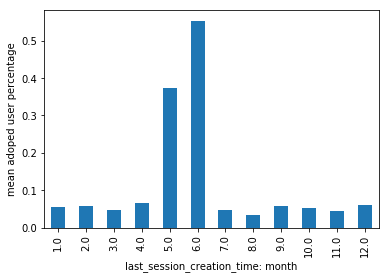

In [334]:
user_df.groupby(user_df.last_session_creation_time.dt.month)['adopted'].mean().plot(kind="bar",color=color[0])
plt.xlabel('last_session_creation_time: month')
plt.ylabel('mean adoped user percentage')
plt.show()

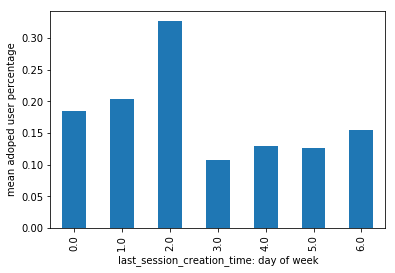

In [335]:
user_df.groupby(user_df.last_session_creation_time.dt.weekday)['adopted'].mean().plot(kind="bar",color=color[0])
plt.xlabel('last_session_creation_time: day of week')
plt.ylabel('mean adoped user percentage')
plt.show()

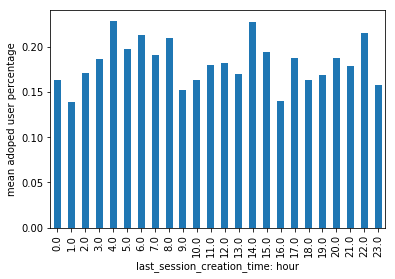

In [338]:
user_df.groupby(user_df.last_session_creation_time.dt.hour)['adopted'].mean().plot(kind="bar",color=color[0])
plt.xlabel('last_session_creation_time: hour')
plt.ylabel('mean adoped user percentage')
plt.show()

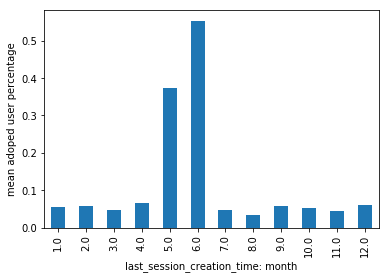

In [339]:
user_df.groupby(user_df.last_session_creation_time.dt.month)['adopted'].mean().plot(kind="bar",color=color[0])
plt.xlabel('last_session_creation_time: month')
plt.ylabel('mean adoped user percentage')
plt.show()

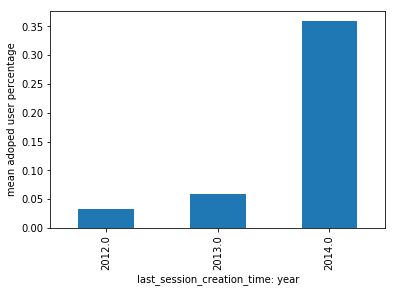

In [340]:
user_df.groupby(user_df.last_session_creation_time.dt.year)['adopted'].mean().plot(kind="bar",color=color[0])
plt.xlabel('last_session_creation_time: year')
plt.ylabel('mean adoped user percentage')
plt.show()

0.12341035285688698
0.1422783232039894


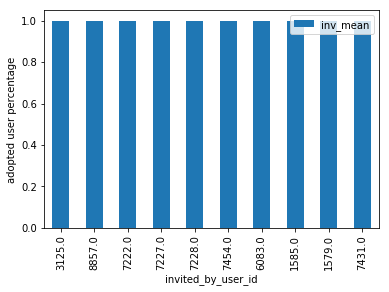

In [341]:
print(user_df[user_df['invited_by_user_id'].isna()]['adopted'].mean())
print(user_df[user_df['invited_by_user_id'] >= 0]['adopted'].mean())
user_inv = user_df.groupby('invited_by_user_id')['adopted'].mean().reset_index(name='inv_mean').sort_values(by='inv_mean',ascending=False)
user_inv.iloc[:10,:].plot(x='invited_by_user_id', y='inv_mean', kind='bar',color=color[0])
plt.ylabel('adopted user percentage')
plt.xlabel('invited_by_user_id')
plt.show()

<div class="alert alert-success">
<b> Summary of EDA: </b>  
- 1602 (13.35%) users out of 12000 signed up users are adopted users: log into   the   product   on   three   separate 
days   in   at   least   one   seven-day   period  
- 3177 (26%) users never log into the product after sign up  
- Adopted user percentage is higher when users signed up by guest invitation or through google authorization, lowest when     users were invited   to   join   another   user's  personal   workspace   
- Users from some organization have higher adopted user percentage than others  
- Users with some email suffix such as @nhxrt.com, @xebtr.com have high adopted user percentage   
- Users who signed up after 2014 April have lower adopted user percentage    
- Users who signed up in April and May have low adopted user percentage   
- Users who lastly signed in 2014 have high adopted user percentage  
- Users who lastly signed in May and June have high adopted user percentage  
- Users who lastly signed in on Wednesday have high adopted user percentage  
- Users invited by some guests such as guest 3125, 8857, 7222 have high adopted user percentage

</div>

# Modeling

In [342]:
print(len(user_df))

# drop rows where email_company only occurs once and last_session_creation_time is NULL to remove fake account
email_count = user_df['email_company'].value_counts().reset_index()
email_count.columns = ['email_company','email_count']
user_df = user_df.merge(email_count,on='email_company',how='left')
user_df.drop(user_df[(user_df.last_session_creation_time.isna()) & (user_df['email_count'] == 1)].index,inplace=True)
print(len(user_df))

12000
11629


In [362]:
# fillna
for i in np.arange(len(user_df)):
    if pd.isnull(user_df.iloc[i]['last_session_creation_time']):        
        user_df.iloc[i,5] = user_df.iloc[i,1]

user_df.loc[user_df['invited_by_user_id'].isna(),'invited_by_user_id'] = -999

# convert time series categorical data to numerical features
user_df['creation_time_year'] = user_df.creation_time.dt.year
user_df['creation_time_month'] = user_df.creation_time.dt.month
user_df['last_session_year'] = user_df.last_session_creation_time.dt.year
user_df['last_session_month'] = user_df.last_session_creation_time.dt.month
user_df['last_session_dow'] = user_df.last_session_creation_time.dt.weekday


In [363]:
# convert categorical data to numerical
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
label = LabelEncoder()
email_label = label.fit_transform(user_df['email_company'])
source_label = label.fit_transform(user_df['creation_source'])
user_df['email_label'] = pd.Series(email_label)
user_df['source_label'] = pd.Series(source_label)
user_df.head(10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,email_company,adopted,email_count,creation_time_year,creation_time_month,last_session_year,last_session_month,last_session_dow,email_label,source_label
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,...,yahoocom,0,2447,2014,4,2014,4,1,763.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,...,gustrcom,1,1179,2013,11,2014,3,0,213.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,...,gustrcom,0,1179,2013,3,2013,3,1,213.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,...,yahoocom,0,2447,2013,5,2013,5,2,763.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,...,yahoocom,0,2447,2013,1,2013,1,1,763.0,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,...,yahoocom,0,2447,2013,12,2013,12,3,763.0,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,-999.0,...,jourrapidecom,0,1259,2012,12,2012,12,3,303.0,3.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,2013-07-31 05:34:02,1,1,74,-999.0,...,yahoocom,0,2447,2013,7,2013,7,2,763.0,2.0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,2013-11-05 04:04:24,0,0,302,-999.0,...,hotmailcom,0,1165,2013,11,2013,11,1,231.0,2.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,...,gustrcom,1,1179,2013,1,2014,6,1,213.0,1.0


In [366]:
fea_list = ['opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','invited_by_user_id','creation_time_year',
           'creation_time_month','last_session_year','last_session_month','last_session_dow','email_label','source_label']
user_df.dropna(inplace=True)
X = user_df[fea_list]
y = user_df['adopted']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11270 entries, 0 to 11628
Data columns (total 11 columns):
opted_in_to_mailing_list      11270 non-null int64
enabled_for_marketing_drip    11270 non-null int64
org_id                        11270 non-null int64
invited_by_user_id            11270 non-null float64
creation_time_year            11270 non-null int64
creation_time_month           11270 non-null int64
last_session_year             11270 non-null int64
last_session_month            11270 non-null int64
last_session_dow              11270 non-null int64
email_label                   11270 non-null float64
source_label                  11270 non-null float64
dtypes: float64(3), int64(8)
memory usage: 1.0 MB


In [367]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=12)

In [368]:
#random forest
#parameter tuning for random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([('scaler',StandardScaler()),('classifier', RandomForestClassifier())])
                      
param_dict = {'classifier__n_estimators':[100,150],'classifier__max_depth':[5,10],'classifier__min_samples_leaf':[2,3],'classifier__max_features':[3,5],'classifier__random_state':[12]}

cv = GridSearchCV(pipeline,param_grid=param_dict)

In [369]:
cv.fit(X_train,y_train)
print(cv.best_params_)
print(cv.best_score_)

{'classifier__max_depth': 10, 'classifier__max_features': 5, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100, 'classifier__random_state': 12}
0.9672962352642921


In [371]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
y_tr_pre = cv.predict(X_train)
y_ts_pre = cv.predict(X_test)
print("accuracy score on train set is:",accuracy_score(y_train,y_tr_pre))
print("f1 score on train set is:",f1_score(y_train,y_tr_pre))
print("area under roc curve on train set is:",roc_auc_score(y_train,y_tr_pre))
print("accuracy score on test set is:",accuracy_score(y_test,y_ts_pre))
print("f1 score on test set is:",f1_score(y_test,y_ts_pre))
print("area under roc curve on test set is:",roc_auc_score(y_test,y_ts_pre))

accuracy score on train set is: 0.9828875649638737
f1 score on train set is: 0.9353757778841553
area under roc curve on train set is: 0.9472245241832948
accuracy score on test set is: 0.9727891156462585
f1 score on test set is: 0.8968609865470852
area under roc curve on test set is: 0.9239758883864208


In [372]:
importances = cv.best_estimator_.named_steps["classifier"].feature_importances_
importances

array([0.00265877, 0.00255743, 0.02835232, 0.02036355, 0.25874054,
       0.28231516, 0.16280742, 0.20306018, 0.01676336, 0.01361942,
       0.00876183])

<div class="alert alert-success">
<b> Summary of modeling: </b>  
- 11 features are used to model whether a user is adopted   
- Random Forest Classification is used since it gives insights on feature importance  
- categorical features are converted to numerical labels   
- Model performs well on both training and test data  
- The most important features are 'creation_time_year','creation_time_month','last_session_month','last_session_year'
</div>